# Data assimilation case study with 1 observables
Corresdong to Chapter 4 of the course "Introduction to digital twin" by Romain CHASSAGNE - https://rlchassagne.github.io/

Problem: What temperature heaters should be set to in order to keep the three relica at 20°C temperature?
Heaters can vary from  [10;90] °C

In [36]:
# MODULE 1: Import Libraries and Setup Parameters
###############################################

import numpy as np
import matplotlib.pyplot as plt

# --- Physical Dimensions ---
ROOM_WIDTH = 10.0  # meters
ROOM_HEIGHT = 10.0 # meters

# --- Grid Resolution ---
N_X = 71  # Number of grid points along X-axis
N_Y = 71  # Number of grid points along Y-axis
DX = ROOM_WIDTH / (N_X - 1)
DY = ROOM_HEIGHT / (N_Y - 1)

# --- Thermal Boundary Conditions (in °C) ---
T_WINDOW_COLD = 0.0   # Temperature of the cold window
T_WALL_COLD = 10.0    # Temperature of unheated/insulated walls
T_RADIATOR_HOT = 46.0 # Temperature of the radiators

# Initial temperature guess for the room
T_INITIAL = 25.0 

# --- Numerical Solver Parameters ---
MAX_ITER = 300000   # Maximum number of iterations allowed
TOLERANCE = 1e-4    # Convergence criteria for steady-state

print(f"Grid setup: {N_X}x{N_Y} points | Node spacing: {DX:.2f}m")
print(f"Objective: Simulate cold walls ({T_WALL_COLD}°C) with active heat sources.")

Grid setup: 71x71 points | Node spacing: 0.14m
Objective: Simulate cold walls (10.0°C) with active heat sources.


In [37]:
# MODULE 2: Initialize Temperature Array and Set Boundary Conditions
####################################################################

# 1. Initialize the temperature array
T = np.full((N_X, N_Y), T_INITIAL)

# --- Calculate dimensions for boundary sources ---
HEAT_SOURCE_LENGTH = int(np.ceil(N_Y / 4)) 
HEAT_COLD_LENGTH = int(np.ceil(N_X / 2))   

# --- NEW: Internal Radiator at (8,8) ---
RAD_PHYS_X, RAD_PHYS_Y = 6.5, 6.0  # target meters
RAD_X_IDX = int(RAD_PHYS_X / DX)
RAD_Y_IDX = int(RAD_PHYS_Y / DY)
RAD_SIZE_NODES = int(0.5 / DX)     # 0.5 meter wide radiator

# --- Define Boundary Conditions (Dirichlet BCs) ---
T[:, 0] = T_WALL_COLD   # Bottom
T[:, -1] = T_WALL_COLD  # Top
T[0, :] = T_WALL_COLD   # Left
T[-1, :] = T_WALL_COLD  # Right

# Overwrite specific sources
T[0:HEAT_COLD_LENGTH, 0] = T_WINDOW_COLD             # Window
T[0, (N_Y - HEAT_SOURCE_LENGTH):N_Y] = T_RADIATOR_HOT # Top Left Radiator
T[-1, 0:HEAT_SOURCE_LENGTH] = T_RADIATOR_HOT          # Bottom Right Radiator

# Apply the internal radiator initially
T[RAD_X_IDX : RAD_X_IDX + RAD_SIZE_NODES, 
  RAD_Y_IDX : RAD_Y_IDX + RAD_SIZE_NODES] = T_RADIATOR_HOT

print(f"Boundary conditions initialized.")
print(f"Internal radiator placed at {RAD_PHYS_X}m, {RAD_PHYS_Y}m (Index: {RAD_X_IDX},{RAD_Y_IDX})")

Boundary conditions initialized.
Internal radiator placed at 6.5m, 6.0m (Index: 45,42)


In [38]:
# MODULE 3: Finite Difference Solver (vectorised version)
###################################################

iteration = 0
max_change = float('inf')

print("⏳ COMPUTING VECTORIZED SOLVER...")

while iteration < MAX_ITER and max_change > TOLERANCE:
    T_old = T.copy() 
    
    # --- 1. VECTORIZED CALCULATION (The core of performance) ---
    # We calculate all internal points [1:-1, 1:-1] at once
    # using matrix offsets (Slicing)
    T[1:-1, 1:-1] = 0.25 * (T[2:, 1:-1] + T[:-2, 1:-1] + 
                            T[1:-1, 2:] + T[1:-1, :-2])
            
    # --- 2. RE-ENFORCING BOUNDARY CONDITIONS ---
    # Cold walls
    T[0, :] = T_WALL_COLD
    T[-1, :] = T_WALL_COLD
    T[:, 0] = T_WALL_COLD
    T[:, -1] = T_WALL_COLD
    
    # Heat sources and Window (Overwriting values on the edges)
    T[0, (N_Y - HEAT_SOURCE_LENGTH):N_Y] = T_RADIATOR_HOT 
    T[-1, 0:HEAT_SOURCE_LENGTH] = T_RADIATOR_HOT
    T[0:HEAT_COLD_LENGTH, 0] = T_WINDOW_COLD
    
    # Internal Radiator (Overwriting values inside the grid)
    T[RAD_X_IDX : RAD_X_IDX + RAD_SIZE_NODES, 
      RAD_Y_IDX : RAD_Y_IDX + RAD_SIZE_NODES] = T_RADIATOR_HOT
    
    # --- 3. CONVERGENCE TEST ---
    max_change = np.max(np.abs(T - T_old))
    
    if iteration % 2000 == 0: 
        print(f"   > Iteration {iteration} | Error: {max_change:.6f}")
    iteration += 1

print(f"✅ COMPLETED in {iteration} iterations.")

⏳ COMPUTING VECTORIZED SOLVER...
   > Iteration 0 | Error: 10.000000
   > Iteration 2000 | Error: 0.001575
   > Iteration 4000 | Error: 0.000118
✅ COMPLETED in 4130 iterations.


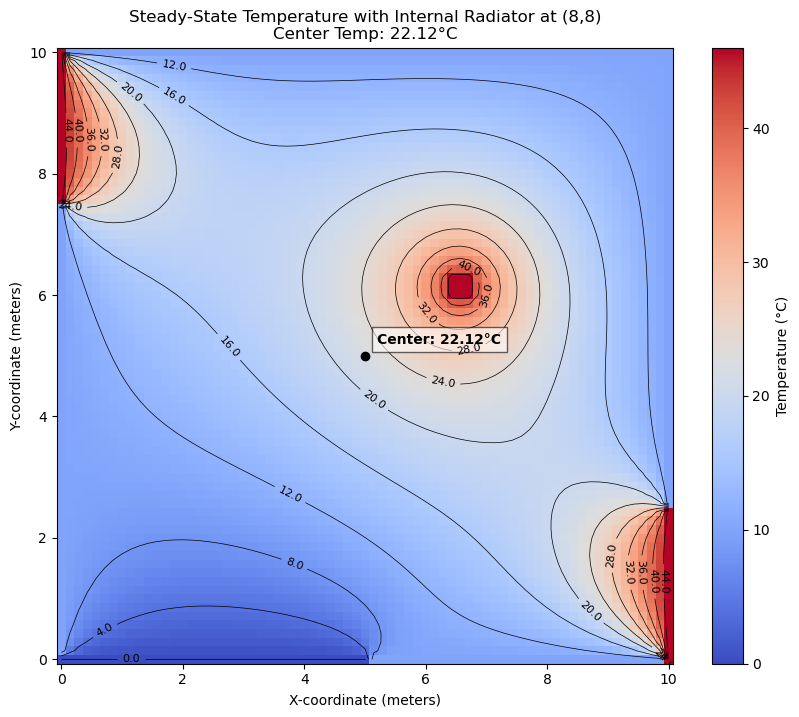

In [39]:
# MODULE 4: Plotting results with center temperature marker
###########################################################
import matplotlib.colors as colors

x = np.linspace(0, ROOM_WIDTH, N_X)
y = np.linspace(0, ROOM_HEIGHT, N_Y)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(10, 8))

# 1. Heatmap
norm = colors.Normalize(vmin=T_WINDOW_COLD, vmax=T_RADIATOR_HOT) 
plt.pcolormesh(X, Y, T.T, cmap='coolwarm', shading='auto', norm=norm) 
plt.colorbar(label='Temperature (°C)')

# 2. Contours
contour = plt.contour(X, Y, T.T, colors='k', linestyles='solid', linewidths=0.5, levels=12)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f') 

# 3. CENTER TEMPERATURE SENSOR
c_i, c_j = N_X // 2, N_Y // 2
c_temp = T[c_i, c_j]
plt.plot(x[c_i], y[c_j], 'ko') # Black dot
plt.text(x[c_i]+0.2, y[c_j]+0.2, f'Center: {c_temp:.2f}°C', 
         fontweight='bold', bbox=dict(facecolor='white', alpha=0.6))

plt.title(f'Steady-State Temperature with Internal Radiator at (8,8)\nCenter Temp: {c_temp:.2f}°C')
plt.xlabel('X-coordinate (meters)')
plt.ylabel('Y-coordinate (meters)')
plt.gca().set_aspect('equal')

plt.savefig("temperature_map_distribution.jpg", dpi=300, bbox_inches='tight')
plt.show()

🚀 Launching assimilation (Method: PSO)
✅ Completed in 2.85s
🌡️ Optimal temperature found: 40.64°C


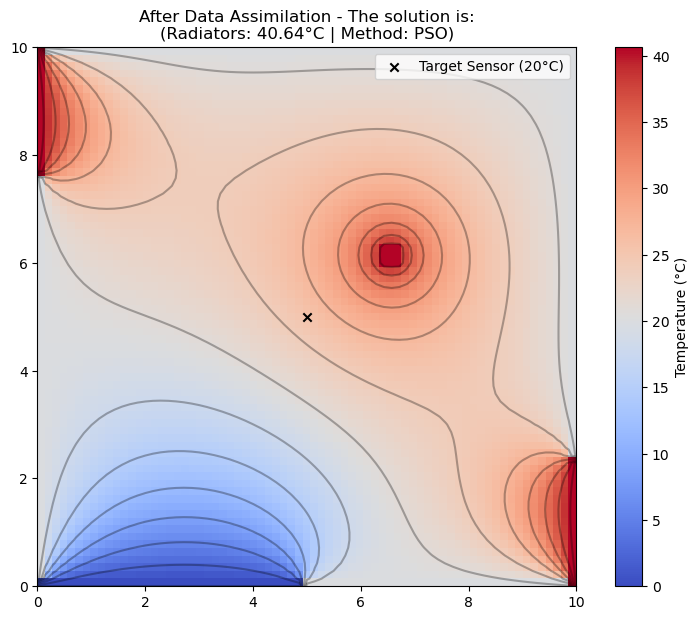

In [44]:
# MODULE 5 - DATA ASSIMILATION with one observable 
# 1 measured temperature point
# bounds value (constrains/search space) are in section 3
########################################################

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import differential_evolution, shgo

# ==========================================================
# 1. CONFIGURATION 
# ==========================================================
# Method Choice: 'DE' (Differential Evolution), 
#                'PSO' (Particle Swarm/SHGO), 
#                'BAYES' (Simplified Bayesian Approach)
CHOSEN_METHOD = 'PSO'  

ROOM_WIDTH, ROOM_HEIGHT = 10.0, 10.0
N_X, N_Y = 71, 71
DX, DY = ROOM_WIDTH / (N_X - 1), ROOM_HEIGHT / (N_Y - 1)

# Fixed Temperatures (°C)
T_WINDOW_COLD = 0.0
T_WALL_COLD = 10.0
T_INITIAL = 20.0
TARGET_TEMP = 20.0  # Observable / Measurement

# Source Geometry
HEAT_SOURCE_LENGTH = int(N_Y / 4)
HEAT_COLD_LENGTH = int(N_X / 2)
RAD_X_IDX, RAD_Y_IDX = int(6.5 / DX), int(6.0 / DY)
RAD_SIZE_NODES = int(0.5 / DX)

# ==========================================================
# 2. PHYSICS ENGINE (VECTORIZED SIMULATOR)
# ==========================================================
def run_simulation(t_radiator_guess):
    """ Calculates the final temperature for a given radiator setting """
    T = np.full((N_X, N_Y), T_INITIAL)
    
    # Vectorized Solver (Fast)
    for _ in range(5000):
        # Laplace Equation (Average of 4 neighbors)
        T[1:-1, 1:-1] = 0.25 * (T[2:, 1:-1] + T[:-2, 1:-1] + 
                                T[1:-1, 2:] + T[1:-1, :-2])
        
        # Re-apply Boundary Conditions (Dirichlet)
        T[0, :] = T_WALL_COLD
        T[-1, :] = T_WALL_COLD
        T[:, 0] = T_WALL_COLD
        T[:, -1] = T_WALL_COLD
        
        # Active Sources (Window and Radiators)
        T[0, (N_Y - HEAT_SOURCE_LENGTH):N_Y] = t_radiator_guess 
        T[-1, 0:HEAT_SOURCE_LENGTH] = t_radiator_guess
        T[RAD_X_IDX : RAD_X_IDX + RAD_SIZE_NODES, 
          RAD_Y_IDX : RAD_Y_IDX + RAD_SIZE_NODES] = t_radiator_guess
        T[0:HEAT_COLD_LENGTH, 0] = T_WINDOW_COLD

    # Returns the value at the center of the room
    return T[N_X // 2, N_Y // 2]

def cost_function(t_guess):
    # We seek to minimize the squared error
    current_temp = run_simulation(t_guess[0])
    return (current_temp - TARGET_TEMP)**2

# ==========================================================
# 3. DATA ASSIMILATION ALGORITHMS
# ==========================================================
bounds = [(10.0, 70.0)]
print(f"🚀 Launching assimilation (Method: {METHODE_CHOISIE})")
start_time = time.time()

if CHOSEN_METHOD == 'DE':
    # Robust, global, but computationally expensive
    res = differential_evolution(cost_function, bounds, popsize=5, tol=0.01)
    best_t = res.x[0]

elif CHOSEN_METHOD == 'PSO':
    # SHGO simulates a global swarm/grid search
    res = shgo(cost_function, bounds, n=12)
    best_t = res.x[0]

elif CHOSEN_METHOD == 'BAYES':
    # Intelligent sampling approach (reduces number of simulations)
    # We test a few points and then refine
    test_temps = np.linspace(10, 70, 6)
    costs = [cost_function([t]) for t in test_temps]
    best_t = test_temps[np.argmin(costs)]

# ==========================================================
# 4. RESULTS AND VISUALIZATION
# ==========================================================
duration = time.time() - start_time
print(f"✅ Completed in {duration:.2f}s")
print(f"🌡️ Optimal temperature found: {best_t:.2f}°C")

# Final simulation with the optimal value for display
T_final = np.full((N_X, N_Y), T_INITIAL)
for _ in range(8000): # More iterations for a smoother render
    T_final[1:-1, 1:-1] = 0.25 * (T_final[2:, 1:-1] + T_final[:-2, 1:-1] + T_final[1:-1, 2:] + T_final[1:-1, :-2])
    T_final[0, (N_Y - HEAT_SOURCE_LENGTH):N_Y] = best_t
    T_final[-1, 0:HEAT_SOURCE_LENGTH] = best_t
    T_final[RAD_X_IDX:RAD_X_IDX+RAD_SIZE_NODES, RAD_Y_IDX:RAD_Y_IDX+RAD_SIZE_NODES] = best_t
    T_final[0:HEAT_COLD_LENGTH, 0] = T_WINDOW_COLD

# Display heatmap
plt.figure(figsize=(10, 7))
im = plt.imshow(T_final.T, origin='lower', cmap='coolwarm', extent=[0, 10, 0, 10])
plt.colorbar(im, label='Temperature (°C)')
plt.contour(T_final.T, colors='black', levels=15, extent=[0, 10, 0, 10], alpha=0.3)
plt.scatter([5], [5], color='black', marker='x', label='Target Sensor (20°C)')
plt.title(f"After Data Assimilation - The solution is:\n(Radiators: {best_t:.2f}°C | Method: {CHOSEN_METHOD})")
plt.legend()
plt.show()